# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Pierre Chassagne 289475
**Author 2 (sciper):** Thomas Peeters 288239   
 

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np   
import cv2           
import scipy
 
from skimage.filters import difference_of_gaussians, window
import skimage.io                         # collection of algorithms for image processing and computer vision
import matplotlib.pyplot as plt
from skimage.feature import canny         # use to compute the edge 
from skimage.morphology import flood_fill # use to fullfill the inside of an closed contour
from scipy import ndimage as ndi          # also use to fullfill the inside of a closed contour
import pandas as pd                       # use to create dataframes


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

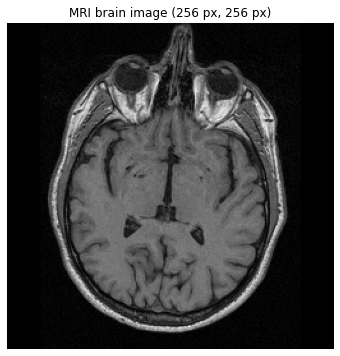

In [2]:
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

#### 1.1.1 Definition of useful functions

In [3]:
"""
Function used to give information on the computation of an algorithm
"""

def progressBar(current, total, barLength = 20):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))

    print('Progress: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')

#### 1.1.2 Binary thresholding and histogram visualization

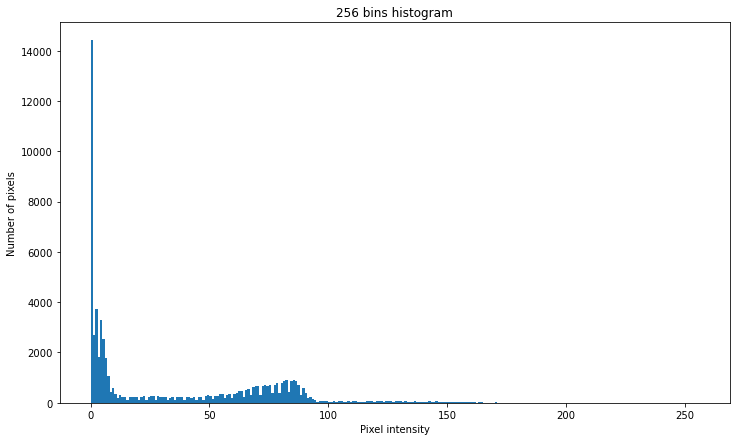

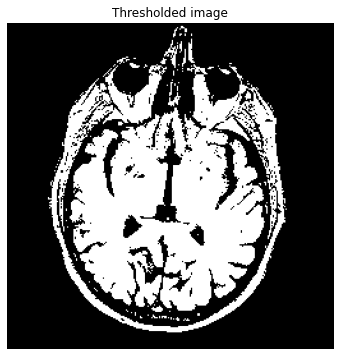

In [4]:
# Histogram visualization :
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(),256, [0,256])
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')
plt.show()

# Binary thresholding
n,threshIm = cv2.threshold(brain_im,60, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(6, 6))
plt.title('Thresholded image')
plt.imshow(threshIm,'gray')
plt.axis('off')
plt.show()

### 1.2 Region growing (5pts)

#### 1.2.1 Definition of the parameters

In [5]:
# used for the region growing algorithm : 
orient = [(1,0), (0,1), (-1,0), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]
seed = [(100,100)]
checked = [(100,100)]


img = brain_im.copy()

#### 1.2.2 RG Algorithm

The region algortim is quite simple, one should take a seed in the region to be detected, here we took the pixel (100,100). Once the seed is set we check all its neigbhors if they are in between the threshold values, set by trial and error, it is marked as a part of the region and added to the seeds, if it is not it is only marked as checked. Once all the neigbhor of a seed have been checked the seed is removed from the list of the seeds.

In [ ]:
while(len(seed) > 0):
    
    for x_i,y_j in seed :
        for i,j in orient :
            x = x_i + i
            y = y_j + j
            
            if (x,y) not in checked :
                
                if (50 < img[x,y]) &  (img[x,y] < 95) :
                    img[x,y] = 255
                    seed.append((x,y))
                checked.append((x,y))
                
        seed.remove((x_i,y_j))
        
img[img[:,:] != 255] = 0

#### 1.2.3 Plot of the results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title('Size of the brain : ' + str(len(img[img == 255])) + ' Pixels')
ax.axis('off')
plt.show()

#### 1.2.4 Discussion of the results

The results given by the region growing algorithm are really good. However the RG algorithm is sensitive to junctions between parts and therefore a good threshold value is important, moreover it is a computationally costly algorithm that could take a while on bigger region. Its main advantage lie in its ability to fit perfectly any shapes due to its really simplist algorithmic. 

To improve the algorithm one could change the condition to mark a pixel as white or fill in all the little gaps which remain in the final image by checking if each region of size inferior or equal to a given size are surounded by white or not.

### 1.3 Contour detection (5pts)

#### 1.3.1 Edge detection using a canny edge detector

In [ ]:
#from skimage.transform import hough_ellipse
#from skimage.draw import ellipse_perimeter

"""
to find the contour, we use an edge detection algorithm using the canny function from skimage.
This filter is based on the derivative of the gaussian. The value of sigma correspond to the standard deviation
of the gaussian filter. 
"""

img2 = brain_im.copy()
edges = canny(img2, sigma=2.2)
img2[edges] = 255
img2[~edges] = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 6), )
ax.imshow(img2, 'gray')
ax.set_title('Edges of the image')
ax.axis('off')
plt.show()

After this step, one can see that these edges can't be exploited since there are no close contour, therefore we will try to close them by dilation.

#### 1.3.2 Dilating the edges to make a closed path and applying a flood fill to extract the brain

In [ ]:
kernel = np.ones((4,4),np.uint8)
img2 = cv2.dilate(img2,kernel,iterations = 1) #we dilate the edge to make a close contour

fig, ax = plt.subplots(1, 1, figsize=(6, 6), )
ax.imshow(img2, 'gray')
ax.set_title('Edges after dilation')
ax.axis('off')
plt.show()

img2 = flood_fill(img2, (100,100), 100)

img2[img2 != 100] = 0
img2[img2 == 100] = 255

#### 1.3.3 Plot the results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), )
ax.imshow(img2, 'gray')
ax.set_title('Size of the brain : ' + str(len(img2[img2==255])) + ' Pixels')
ax.axis('off')
plt.show()

#### 1.3.4 Discussion of the results

Trying to extract the brain only by using contour detection is a hard task. Indeed one can easily find the contour of the brain, however it is often not a close contour or there are wrong contours detected due to noise. Hence it is not sufficient to use only edge detection in order to detect the contours and then extract the brain. Edge detection is used more as a pre-processing step than an extraction algorithm. One can then use morphology to try and get better results. Hence the results that the contour detection method gives are poor results compared to the region growing algorithm for example. However if one doesn't need a good precision the algortihm is really fast and easy to compute.

### 1.4 Additional method (5pts)

Here we chose the simplicity, indeed we realized that the brain could be easily extracted with a circular mask, so we implemented a function to create a circular mask and we pre-processed the image in order to get the best results.

In [ ]:
# function to create a circular mask
def mask_circle(h, w, center, radius):


    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

#### 1.4.1 Gaussian blurr to denoise the image

In [ ]:
brain_blur = skimage.filters.gaussian(brain_im, sigma=1)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_blur, cmap='gray')
ax.set_title('Blurred brain image'.format(im_h, im_w))
ax.axis('off')
plt.show()

#### 1.4.2 Threshold

In [ ]:
thresh_mask = (brain_blur< 0.38) & (brain_blur > 0.20)

thresh_im = brain_blur.copy()
thresh_im[thresh_mask] = 255
thresh_im[~thresh_mask] = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(thresh_im, cmap='gray')
ax.set_title('Thresholded blurred image'.format(im_h, im_w))
ax.axis('off')
plt.show()

#### 1.4.3 Applying a mask and visualizing the results

In [ ]:
center_mask=(int(im_w/2.05), int(2*im_h/3.42))
radius_mask=im_h*1/3.2

circular_mask=mask_circle(im_h, im_w, center_mask, radius_mask)

brain_img = thresh_im.copy()
brain_img[~circular_mask] = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_img, cmap='gray')
ax.set_title('Size of the brain : ' + str(len(brain_img[brain_img==255])) + ' Pixels')
ax.axis('off')
plt.show()

#### 1.4.4 Discussion on the results

Creating a mask to exctract the brain, after pre-processing it, gives really great results given the simplicity of the algorithm and its cheap computation cost, however this method is not robust to change on the images and one would have to center manually the mask each time to have good results. But with a standardize procedure that ensure the image to be well centered and oriented this method can be really efficient.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### Explanation : 

The first thing to do is to have some intensity normalization to be more robust to illumination changes. To do that, we use the min max method. We will convert the values of each pixel using this formula: (x-xmin)/(x_max-x_min). With this formula each image have its min value equal to 0 and its max value equal to 1. 

After the intensity normalization, we need to extract the different shapes of the images. We can use different methods such as using a treshold to separate the different shapes from the background. In our case we decided to use the contour detection from the first part as the shape are simple and the edges easy to compute.

Once we found the different shapes, we use an algorithm to extract the differents features from each shapes such as : the list of pixels corresponding to one shape, the size in pixel of the shape, the mean intensity (in red, green and blue) of each shape. 

To separate the different shapes, we use a treshold on the size in pixel of each shape. If the size in pixel is lower than the first treshold, it correspond to the "minus" shape. If the size is in between the two tresholds, it correspond to the shape "plus" and if it is higher than the second treshold, it correspond to the "*" shape. 

To get the area in pixels of each colour we separate the shapes into two colour_classes (black and blue). To do that we use a kmeans algortihm using as feature the mean intensity in red green and blue of each shape. This method is useful in this situation because it is robust to illumination changes. Once we obtain the list of shapes of each colour, we sum the size in pixels of each shapes to get the area in pixel of each colour. 


#### Normalization

For the normalization we use the cv2 function 'normalize' that will normalize the image using the min max method. The 
value of each pixel will be rescale using this formula: 

x_new = (x-x_min)/(x_max-x_min)

In [ ]:
img0=images[0,:,:,:]
img0 = skimage.filters.gaussian(img0, sigma=1,multichannel=False)
norm0 = cv2.normalize(img0, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

img1=images[1,:,:,:]
img1 = skimage.filters.gaussian(img1, sigma=1,multichannel=False)
norm1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

img2=images[2,:,:,:]
img2 = skimage.filters.gaussian(img2, sigma=1,multichannel=False)
norm2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


# We plot the three normalized images : 

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(norm0, cmap='gray')
ax.set_title('Normalized images'.format(im_h, im_w))
ax.axis('off')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(norm1, cmap='gray')
ax.axis('off')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(norm2, cmap='gray')
ax.axis('off')
plt.show()

#### choose the image you want to work with 

In [ ]:
# Choose which image you want to work with : 
image=norm1.copy()     #norm1,norm2 or norm3

### 2.2 Number of shapes of each color (5 pts)

To find the different shapes, we use an edge detection algorithm using the canny function from skimage.
This filter is based on the derivative of the gaussian. To use this canny function, we need to convert our RGB 
image to a greyscale image. The value of sigma correspond to the standard deviation of the gaussian filter. 

In [ ]:
grey=skimage.color.rgb2gray(image[:,:,:])
edges = canny(grey,sigma=2)

#edges=skimage.morphology.binary_dilation(edges, selem=None, out=None)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(edges, cmap='gray')
ax.set_title('Edges of each shape')
ax.axis('off')
plt.show()

shape = ndi.binary_fill_holes(edges) # the function binary_fill_holes will fill the closed contour region of the different shapes. 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(shape, cmap='gray')
ax.set_title('All the shapes filled in white')
ax.axis('off')
plt.show()

In [ ]:
"""
This function is used to find the pixels corresponding to one shape (based on region growing). It will also 
calculate the size in pixel of the shape, the mean intensity in Red, Green and blue of the shape 
and it will select the class of the shape (star, plus or minus)
"""



def compute_shape(im,imRGB,x_init,y_init):
    orient = [(1,0), (0,1), (-1,0), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]
    seed = [(x_init,y_init)]
    checked = [(x_init,y_init)]
    found = [(x_init, y_init)]
    
    while seed != []:
        for x_i,y_j in seed :
            for i,j in orient :
                x = x_i + i
                y = y_j + j
            
                if (x,y) not in checked :
                
                    if im[x,y] == True :
                        found.append((x,y))
                        seed.append((x,y))    
                    checked.append((x,y))
            
            seed.remove((x_i,y_j))
    size=len(found)
    
    # use treshold to find the class of each shape (-,+ or *)
    tresh_shape1=850
    tresh_shape2=1250
    if size<tresh_shape1:
        shape_format='shape_1'
    if (size<tresh_shape2) & (size>tresh_shape1):
        shape_format='shape_2'
    if size>tresh_shape2:
        shape_format='shape_3'
    
    # find the mean intensity of each shape 
    I,J = np.transpose(found)
    meanR=imRGB[I,J,0].mean()
    meanG=imRGB[I,J,1].mean()
    meanB=imRGB[I,J,2].mean()
    return found,size,shape_format,meanR,meanG,meanB

In [ ]:
 """
algorithm use to extract all the useful informations from each shape. This algorithm will check each pixel from the image. If one 
pixel is equal to True (means that this pixel is part of a shape) and that this pixel have not been checked already,
we call the function 'compute_shape()' that will use region growing to find all the pixels corresponding to one shape and will 
extract all the useful features. 
"""

h=images.shape[1]
w=images.shape[2]
number_of_shape=0
shape_pix={} # dictionnary to stack the pixels corresponding to one shape


class_shape=[] # stack the class of each shape (-,+ or *)
checked=[] # all the pixels that have already been checked
size_shape=[] # size in pixel of each shape
mean_R=[] # mean Red colour intensity of the shape
mean_G=[] # mean green colour intensity of the shape
mean_B=[] # mean blue colour intensity of the shape
color=[] # list that stack the mean colour of the shape in the format [(R1,G1,B1),(R2,G2,B2)..]. It will be useful in the 
        # second part to separate the black and the blue shape. 

for i in range (h):
    for j in range (w):
        if (shape[i,j] == True) :
            if ((i,j) not in checked) :
                my_list,size_list,shape_format,color_R,color_G,color_B = compute_shape(shape,image,i,j)
                
                name="shape_{}".format(number_of_shape)
                size="size_{}".format(number_of_shape)
                number_of_shape+=1
                checked.extend(my_list)
                shape_pix[name]=my_list
                size_shape.append(size_list)
                class_shape.append(shape_format)
                mean_R.append(color_R)
                mean_G.append(color_G)
                mean_B.append(color_B)
                
                color.append([color_R,color_G,color_B])

In [ ]:
# plot the different shapes separetly

black_image =np.zeros((480,640,3))
I,J = np.transpose(shape_pix['shape_9']) #replace the value after shape with a value between 0 and 9
black_image[I,J] = [255,255,255]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(black_image, cmap='gray')
ax.set_title('One extracted shape')
ax.axis('off')
plt.show()

Once we get the mean colours of each shape. We use a bit of machine learning, especially the Kmeans algorithm to separate the points in two classes 
(black shape and blue shapes).

In [ ]:
# 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(color)
kmeans.labels_

In [ ]:
# keep all the information of the different shapes in a dataframe

shape_struc={'size':size_shape,'class':class_shape,'mean_R': mean_R,'mean_G': mean_G,'mean_B': mean_B,'class_color':kmeans.labels_}
shape_features = pd.DataFrame(shape_struc)
shape_features 

### 2.3 Total area (in pixels) of each color (5 pts)

To find the total area in pixel of each color, we select from our dataframe all the shape corresponding to colour zero and 
we sum the size of each shape. 
We check which class_color has the maximum intensity in blue to find which colour correspond to blue. 


In [ ]:
class0=shape_features [shape_features ['class_color']==0]
class1=shape_features [shape_features ['class_color']==1]

if class1['mean_B'].sum()>class0['mean_B'].sum():
    print('total area of blue pixel :',class1['size'].sum())
    print('total area of black pixel :',class0['size'].sum())
else:
    print('total area of blue pixel :',class0['size'].sum())
    print('total area of black pixel :',class1['size'].sum())    
